# Disease_Similarity_Benchmark

## Load Data

In [1]:
# imports

import logging, sys, os
from tqdm import tqdm
import numpy as np, pandas as pd

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)


# functions
def get_processed_ids():
    """Get processed ids
    Returns:
        list: list of processed ids
    """
    data_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")
    return [f.split("_")[0] for f in os.listdir(data_path)]


# Load the all genes per (human) signature


def get_signatures(dsaid, remove_duplicates=True):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..",
        "data",
        "DiSignAtlas",
        "dsa_diff_download.processed",
        f"{dsaid}_alldiff.txt",
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["GeneID"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["GeneID"].tolist()
        p_values = df_cleaned["PValue"].tolist()
        adj_p_values = df_cleaned["AdjPValue"].tolist()
        log2fc = df_cleaned["Log2FC"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download.processed",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["geneid"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["geneid"].tolist()
        p_values = df_cleaned["pvalue"].tolist()
        adj_p_values = df_cleaned["adjpvalue"].tolist()
        log2fc = df_cleaned["log2fc"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc


# get all entrez protein-coding human ids
def get_human_entrez_protein_coding_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID", "type_of_gene"])
    df_human = df[(df["#tax_id"] == 9606) & (df["type_of_gene"] == "protein-coding")]
    logging.info(f"Nº of Human protein coding genes: {len(df_human)}")
    return df_human["GeneID"].to_list()


# load data

processed_ids = get_processed_ids()
logging.info(f"Nº of processed ids: {len(processed_ids)}")

df_data_info = pd.read_csv(data_info_path)

df_data_info_processed = df_data_info.copy()

df_data_info_processed = df_data_info_processed[
    df_data_info_processed["dsaid"].isin(processed_ids)
]

logging.info(f"Nº of processed ids in df_data_info: {len(df_data_info_processed)}")

df_data_info_processed_filtered = df_data_info_processed[
    (df_data_info_processed["organism"] == "Homo sapiens")
    & (
        (df_data_info_processed["library_strategy"] == "Microarray")
        | (df_data_info_processed["library_strategy"] == "RNA-Seq")
    )
]
logging.info(
    f"Nº of Filtered by library (filter out single cell): {df_data_info_processed_filtered.shape}"
)

2024-02-09 11:38:01,242 - INFO - Nº of processed ids: 7191
2024-02-09 11:38:01,405 - INFO - Nº of processed ids in df_data_info: 7191
2024-02-09 11:38:01,407 - INFO - Nº of Filtered by library (filter out single cell): (7001, 12)


In [2]:
# get all entrez protein-coding human ids
human_entrez_protein_coding_ids = get_human_entrez_protein_coding_ids()

2024-02-09 11:39:15,357 - INFO - Nº of Human protein coding genes: 20607


In [3]:
thr_counts = 5
disease_2_counts = dict(df_data_info_processed_filtered["disease"].value_counts())

diseases_high_counts = [k for k, v in disease_2_counts.items() if v >= thr_counts]

logging.info(
    f"Nº of Diseases for Benchmark {len(diseases_high_counts)} / {len(disease_2_counts)}"
)

2024-02-09 11:39:15,435 - INFO - Nº of Diseases for Benchmark 276 / 1428


In [4]:
all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

disease_2_dsaids = dict()
for k, v in tqdm(zip(all_diseases, all_dsaids)):
    if k not in disease_2_dsaids.keys():
        disease_2_dsaids[k] = list()
    disease_2_dsaids[k].append(v)

7001it [00:00, 3339511.24it/s]


In [5]:
from tqdm.contrib.concurrent import process_map


human_dsaids_processed = df_data_info_processed_filtered["dsaid"].to_list()
human_library_processed = df_data_info_processed_filtered["library_strategy"].to_list()

signatures = process_map(
    get_signatures,
    human_dsaids_processed,
    max_workers=8,
    chunksize=10,
)

/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 7001/7001 [03:14<00:00, 36.03it/s]


## Signatures w/ low sparsity

In [6]:
# imports

from collections import Counter

# variabels

# functions


def get_diff_dsaids(dsaids, dsaids_human):
    """Get human dataset ids which are different
    Arguments:
        - dsaids_human (list): dsaids of interest
        - dsaids (list): dsaids which are human
    Returns:
        - dsaids _diff_subsample (list): same nº as dsaids of interest,
        but different ones
    """
    import random

    N = len(dsaids)
    dsaids_diff = list(set(dsaids_human) - set(dsaids))
    dsaids_diff_subsample = random.sample(
        dsaids_diff,
        k=N,
    )
    logging.info(f"Sampled {len(dsaids_diff_subsample)} random different dsaids")
    return dsaids_diff_subsample

In [7]:
all_gene_ids = [s for signature in signatures for s in set(signature[2])]
counts_all_gene_ids = Counter(all_gene_ids)

counts_all_gene_ids_protein_coding = dict()
for k, v in counts_all_gene_ids.items():
    if k in human_entrez_protein_coding_ids:
        counts_all_gene_ids_protein_coding[k] = v

In [8]:
print(counts_all_gene_ids.most_common(10000)[-1])
sorted_counts_all_gene_ids_protein_coding = [
    (k, v)
    for k, v in sorted(
        counts_all_gene_ids_protein_coding.items(),
        key=lambda item: item[1],
        reverse=True,
    )
]

(133418, 5893)


In [9]:
thr = 6215
most_common_gene_ids = [
    k for k, v in counts_all_gene_ids_protein_coding.items() if v >= thr
]

logging.info(f"Most common gene ids: {len(most_common_gene_ids)}")

2024-02-09 11:42:52,894 - INFO - Most common gene ids: 7383


In [10]:
# sort gene ids
most_common_gene_ids = sorted(most_common_gene_ids)

# create data matrix
data_matrix = np.zeros((len(human_dsaids_processed), len(most_common_gene_ids)))

# dsaids w/ gene ids
dsaids_common_gene_ids = [
    s[0]
    for s in signatures
    if len(set(s[2]).intersection(most_common_gene_ids))
    > len(most_common_gene_ids) * 0.95
]


logging.info(f"Nº of dsaids w/ common gene ids: {len(dsaids_common_gene_ids)}")

2024-02-09 11:42:57,205 - INFO - Nº of dsaids w/ common gene ids: 5876


### Adjusted p-Value

In [241]:
# imports


# variables
metric_evaluated = "Log2FC"
d_default_value = {"AdjPValue": 1.0, "Log2FC": 0.0}
data_matrix_low_sp = np.zeros((len(dsaids_common_gene_ids), len(most_common_gene_ids)))
variance_thr = 0.0
assert metric_evaluated in ["AdjPValue", "Log2FC"], "Err metric not found"
# functions


def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


# matrix w/ common gene ids
zero_variance_dsaids_all_genes = list()
zero_variance_dsaids_specific_genes = list()
dsaids_matrix = list()
rows_filled = 0
for i, dsaid_specific in enumerate(tqdm(dsaids_common_gene_ids)):
    # get index of dsaid
    idx = human_dsaids_processed.index(dsaid_specific)

    # retrieve signature
    signature = signatures[idx]

    # quality check
    assert signatures[idx][0] == dsaid_specific, "Err not matching dsaid"

    # get values
    gene_ids = signature[2]
    p_values = signature[3]
    adj_p_values = signature[4]
    log2fc = signature[5]

    # check variance for all genes
    if (np.var(adj_p_values) == variance_thr) or (np.var(log2fc) == variance_thr):
        zero_variance_dsaids_all_genes.append(dsaid_specific)
        continue

    # sort values
    if metric_evaluated == "AdjPValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=adj_p_values,
        )
    elif metric_evaluated == "Log2FC":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=log2fc,
        )

    # check variance for specific genes
    if np.var(sorted_values) == variance_thr:
        zero_variance_dsaids_specific_genes.append(dsaid_specific)
        continue

    # fill rows with data
    for j, value in enumerate(sorted_values):
        data_matrix_low_sp[rows_filled, j] = value

    # if it passes check ! !
    rows_filled += 1
    dsaids_matrix.append(dsaid_specific)


# remove rows not filled
data_matrix_low_sp = data_matrix_low_sp[:rows_filled, :]
logging.info(f"Data matrix shape: {data_matrix_low_sp.shape}")


# report how many dsaids have zero variance
logging.info(f"Zero variance dsaids all genes: {len(zero_variance_dsaids_all_genes)}")
logging.info(
    f"Zero variance dsaids specific genes: {len(zero_variance_dsaids_specific_genes)}"
)

# check zero variance genes
count = 0
for j in range(data_matrix_low_sp.shape[1]):
    if np.var(data_matrix_low_sp[:, j]) == 0:
        count += 1
assert count == 0, "Err zero variance genes"

# check zero variance dsaids
count = 0
for i in range(data_matrix_low_sp.shape[0]):
    if np.var(data_matrix_low_sp[i]) == 0:
        count += 1
assert count == 0, "Err zero variance dsaids"


# mask where there are nans
nan_mask = np.isnan(data_matrix_low_sp)

# assign nans default value
data_matrix_low_sp[nan_mask] = d_default_value.get(metric_evaluated)

100%|██████████| 5876/5876 [00:23<00:00, 250.55it/s]
2024-02-09 16:46:40,915 - INFO - Data matrix shape: (5855, 7383)
2024-02-09 16:46:40,915 - INFO - Zero variance dsaids all genes: 21
2024-02-09 16:46:40,915 - INFO - Zero variance dsaids specific genes: 0


In [242]:
# get diseases of interest
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)


count_diseases = Counter([dsaid_2_disease[dsaid] for dsaid in dsaids_common_gene_ids])
diseases_to_check = [k for k, v in count_diseases.items() if v >= 5]
logging.info(f"Nº of most common diseases: {len(diseases_to_check)}")

# get disease to dsaids of interest
dsaid_2_disease_filtered = dict()

all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

# loop through all diseases
for disease, dsaid in zip(all_diseases, all_dsaids):
    # loop through diseases of interest
    if disease in diseases_to_check:
        # check if dsaids are in matrix ids
        if dsaid in dsaids_matrix:
            if disease not in dsaid_2_disease_filtered.keys():
                dsaid_2_disease_filtered[disease] = list()
            dsaid_2_disease_filtered[disease].append(dsaid)


most_common_diseases = [k for k, v in dsaid_2_disease_filtered.items() if len(v) >= 5]

logging.info(f"Size disease to dsaids: {len(most_common_diseases)}")

2024-02-09 16:46:41,377 - INFO - Nº of most common diseases: 233
2024-02-09 16:46:41,518 - INFO - Size disease to dsaids: 233


/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 400x400 with 0 Axes>

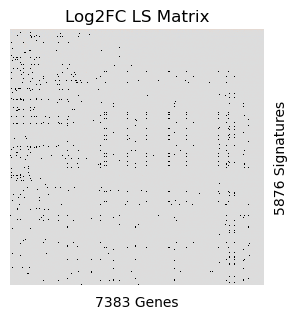

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))


# Set the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color="black")

if metric_evaluated == "AdjPValue":
    min_val = 0
    max_val = 1
elif metric_evaluated == "Log2FC":
    min_val = -3
    max_val = 3

# Plot the clustermap without dendrograms and color bar
cg = sns.clustermap(
    data_matrix_low_sp,
    cmap=cmap,
    mask=nan_mask,
    row_cluster=True,
    col_cluster=True,
    # dendrogram_ratio=(0.1, 0.1),  # Very small dendrogram size
    figsize=(4, 4),  # Control the size of the clustermap here
    cbar_pos=None,
    vmin=min_val,
    vmax=max_val,
)  # No color bar

# Suppress dendrograms
cg.ax_row_dendrogram.set_visible(False)  # suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False)  # suppress column dendrogram

# Remove x and y labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])

# Set axis labels
cg.ax_heatmap.set_xlabel(f"{len(most_common_gene_ids)} Genes")  # Set x-axis label
cg.ax_heatmap.set_ylabel(
    f"{len(dsaids_common_gene_ids)} Signatures"
)  # Set y-axis label

cg.ax_heatmap.tick_params(axis="both", which="both", length=0)  # Remove tick lines

plt.title(f"{metric_evaluated} LS Matrix")

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"cluster_map.LS.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [256]:
min_val

-196.53514021826888

<Axes: >

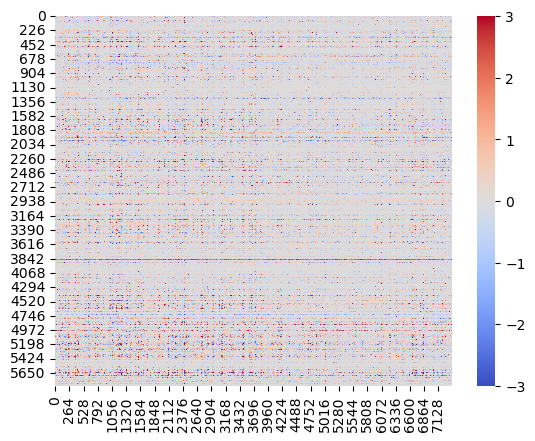

In [261]:
sns.heatmap(data_matrix_low_sp, cmap=cmap, vmin=-3, vmax=3)

In [244]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform


def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


from tqdm import tqdm

correlation_values_interest_all = list()
correlation_values_rest_all = list()

correlation_values_interest_mean = list()
correlation_values_rest_mean = list()

euclidean_values_interest_all = list()
euclidean_values_rest_all = list()

euclidean_values_interest_mean = list()
euclidean_values_rest_mean = list()

cosine_values_interest_all = list()
cosine_values_rest_all = list()

cosine_values_interest_mean = list()
cosine_values_rest_mean = list()

all_indexes = set(range(len(dsaids_matrix)))
for disease in tqdm(most_common_diseases):
    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=100
    )

    # matrix interest
    matrix_interest = data_matrix_low_sp[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix_low_sp[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    # save correlation
    correlation_values_interest_all.append(correlation_values_interest)
    correlation_values_rest_all.append(correlation_values_rest)

    correlation_values_interest_mean.append(np.mean(correlation_values_interest))
    correlation_values_rest_mean.append(np.mean(correlation_values_rest))

    # compute euclidean distance
    euclidean_values_interest = compute_euclidean_distance(
        data_matrix_1=matrix_interest, data_matrix_2=None
    )
    euclidean_values_rest = compute_euclidean_distance(
        data_matrix_1=matrix_interest, data_matrix_2=matrix_rest
    )

    # save euclidean distance
    euclidean_values_interest_all.append(euclidean_values_interest)
    euclidean_values_rest_all.append(euclidean_values_rest)

    euclidean_values_interest_mean.append(np.mean(euclidean_values_interest))
    euclidean_values_rest_mean.append(np.mean(euclidean_values_rest))

    # compute cosine distance
    cosine_values_interest = compute_cosine_distance(
        data_matrix_1=matrix_interest, data_matrix_2=None
    )
    cosine_values_rest = compute_cosine_distance(
        data_matrix_1=matrix_interest, data_matrix_2=matrix_rest
    )

    # save cosine distance
    cosine_values_interest_all.append(cosine_values_interest)
    cosine_values_rest_all.append(cosine_values_rest)

    cosine_values_interest_mean.append(np.mean(cosine_values_interest))
    cosine_values_rest_mean.append(np.mean(cosine_values_rest))

    # check for NaN values
    if any(np.isnan(correlation_values_interest_mean)):
        print(f"NaN correlation found for disease: {disease}")
        print(f"Interest Indices: {interest_idxs}")
        raise ValueError("NaN correlation found")

  0%|          | 0/233 [00:00<?, ?it/s]

100%|██████████| 233/233 [01:42<00:00,  2.26it/s]


In [15]:
# correlation_values_rest_all_flat = [
#     e for sublist in correlation_values_rest_all for e in sublist
# ]

# correlation_values_interest_all_flat = [
#     e for sublist in correlation_values_interest_all for e in sublist
# ]

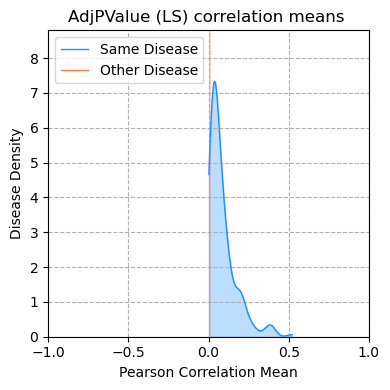

In [70]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Given data
# value_1 = correlation_values_interest_all_flat
# value_2 = np.random.choice(
#     correlation_values_rest_all_flat,
#     size=len(value_1) * 1,
#     replace=False,
# )

value_1 = correlation_values_interest_mean
value_2 = correlation_values_rest_mean

# Plot setup
plt.figure(figsize=(4, 4))
colors = {0: "#1E90FF", 1: "#FF7F50"}

# Plot distribution for value_1
density_1 = stats.gaussian_kde(value_1)
x_1 = np.linspace(min(value_1), max(value_1), 100)
plt.plot(x_1, density_1(x_1), linewidth=1, label="Same Disease", color=colors[0])
plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[0])

# Plot distribution for value_2
density_2 = stats.gaussian_kde(value_2)
x_2 = np.linspace(min(value_2), max(value_2), 100)
plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color=colors[1])
plt.fill_between(x_2, density_2(x_2), alpha=0.3, color=colors[1])

# Finalizing plot
plt.title(f"{metric_evaluated} (LS) correlation means ")
plt.legend()
plt.xlabel("Pearson Correlation Mean")
plt.xlim(-1, 1)
plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Density")
plt.grid(linestyle="--")
plt.tight_layout()

# plt.savefig(
#     os.path.join(
#         "..",
#         "results",
#         "figures",
#         "DiSignAtlas",
#         f"pearson_correlation.LS.{metric_evaluated}.png",
#     ),
#     dpi=300,
#     bbox_inches="tight",
# )

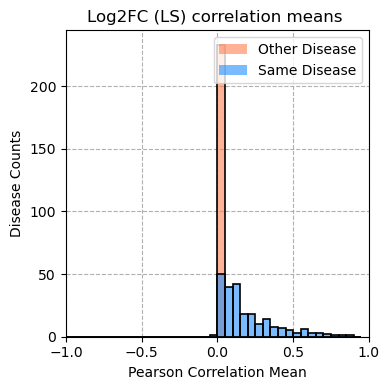

In [245]:
value_1 = correlation_values_interest_mean
value_2 = correlation_values_rest_mean


colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [i for i in np.arange(-1, 1, 0.05)]

# Create figure
plt.figure(figsize=(4, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Finalizing plot
plt.title(f"{metric_evaluated} (LS) correlation means ")
plt.legend()
plt.xlabel("Pearson Correlation Mean")
plt.xlim(-1, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Counts")
plt.grid(linestyle="--")
plt.tight_layout()


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pearson_correlation.LS.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

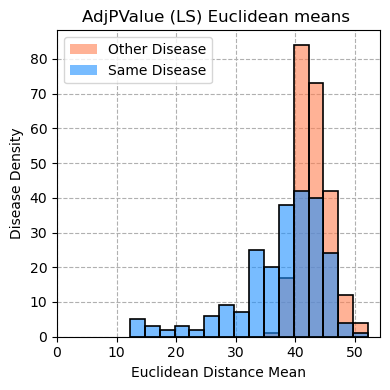

In [118]:
value_1 = euclidean_values_interest_mean
value_2 = euclidean_values_rest_mean

colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [
    i
    for i in np.arange(
        min(euclidean_values_interest_mean + euclidean_values_rest_mean),
        max(euclidean_values_interest_mean + euclidean_values_rest_mean),
        2.5,
    )
]


# Create figure
plt.figure(figsize=(4, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Finalizing plot
plt.title(f"{metric_evaluated} (LS) Euclidean means ")
plt.legend()
plt.xlabel("Euclidean Distance Mean")
plt.xlim(
    0,
)
plt.ylabel("Disease Density")
plt.grid(linestyle="--")
plt.tight_layout()

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"euclidean.LS.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

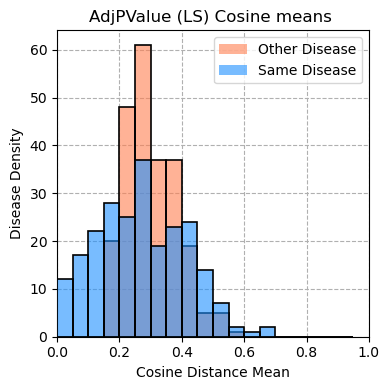

In [121]:
value_1 = cosine_values_interest_mean
value_2 = cosine_values_rest_mean

colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [
    i
    for i in np.arange(
        0,
        1,
        0.05,
    )
]


# Create figure
plt.figure(figsize=(4, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Finalizing plot
plt.title(f"{metric_evaluated} (LS) Cosine means ")
plt.legend()
plt.xlabel("Cosine Distance Mean")
plt.xlim(0, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Density")
plt.grid(linestyle="--")
plt.tight_layout()


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"cosine.LS.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

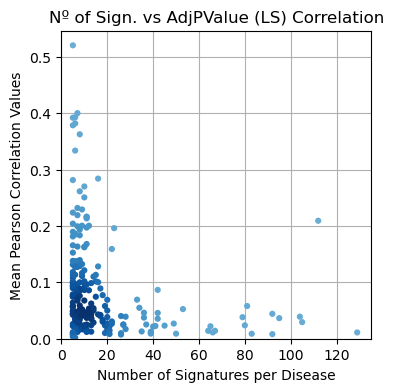

In [240]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

# number of signatures per disease
n_signatures_per_disease = [
    len(dsaid_2_disease_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, correlation_values_interest_mean])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(
    n_signatures_per_disease, correlation_values_interest_mean, 1
)
r_squared = (
    np.corrcoef(n_signatures_per_disease, correlation_values_interest_mean)[0, 1] ** 2
)

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    n_signatures_per_disease,
    correlation_values_interest_mean,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
plt.title(f"Nº of Sign. vs {metric_evaluated} (LS) Correlation")
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Pearson Correlation Values")
plt.xlim(
    0,
)
plt.ylim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        "scatter_plot.diseases_correlation.LS.adj_p_values.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

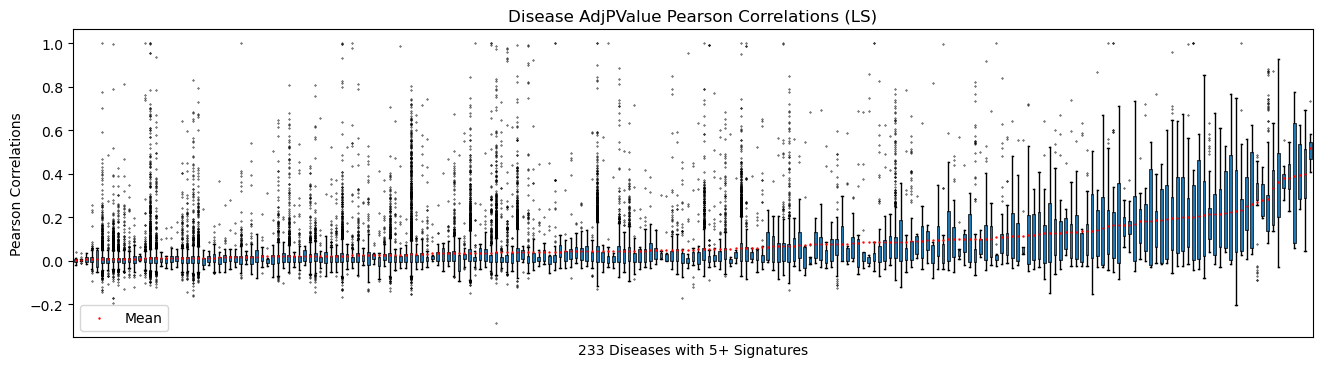

In [239]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = correlation_values_interest_all
# Calculate means and sort data based on these means
means = correlation_values_interest_mean
sorted_indices = np.argsort(means)
sorted_data = [data[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_diseases = [most_common_diseases[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(16, 4))  # Adjusted for visibility

flierprops = dict(marker=".", color="black", markersize=0.8)  # Customizing outliers
boxprops = dict(linestyle="solid", linewidth=0.5, color="black")
medianprops = dict(linestyle="-", linewidth=0)
# Boxplot
bp = plt.boxplot(
    sorted_data,
    vert=True,
    patch_artist=True,
    positions=range(1, int(len(sorted_means) / 1) + 1),
    flierprops=flierprops,
    boxprops=boxprops,
    medianprops=medianprops,
    # Apply outlier customization
)  # Adjusted for visibility

# Overlay means
plt.scatter(
    range(1, int(len(sorted_means) / 1) + 1),
    sorted_means,
    color="red",
    zorder=3,
    label="Mean",
    s=0.5,
)  # Adjusted for visibility

# Customization
plt.title(f"Disease {metric_evaluated} Pearson Correlations (LS)")
plt.xlabel(f"{len(means)} Diseases with 5+ Signatures")
plt.ylabel("Pearson Correlations")
plt.xticks([])
plt.legend()
# plt.ylim(-1, 1)

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"boxplot.diseases_correlation.LS.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

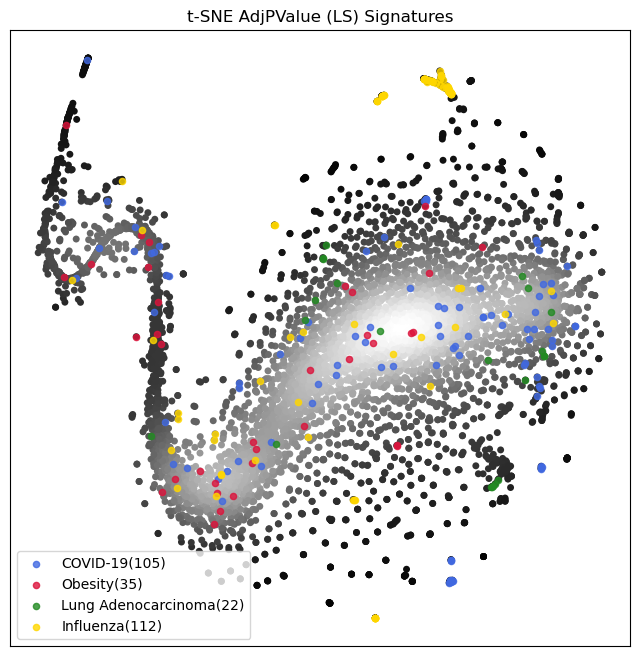

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

single_disease_examples = [
    "COVID-19",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=10)
embedded_data = tsne.fit_transform(data_matrix_low_sp)


# Standardize the t-SNE embeddings (important for density calculation)
scaler = StandardScaler()
scaled_embedded_data = scaler.fit_transform(embedded_data)

# Calculate the density of points in the t-SNE space using Gaussian KDE
bandwidth = 0.3  # Bandwidth parameter for KDE
kde = gaussian_kde(scaled_embedded_data.T, bw_method=bandwidth)
density = kde(scaled_embedded_data.T)

# Create a scatter plot with colors based on local density
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embedded_data[:, 0],
    embedded_data[:, 1],
    c=density,
    cmap="grey",
    s=25,
    edgecolor="none",
)

# specific indexes
d_disease_2_index = dict()
for i, disease in enumerate(single_disease_examples):
    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    plt.scatter(
        embedded_data[interest_idxs, 0],
        embedded_data[interest_idxs, 1],
        color=colors[i],
        label=f"{disease}({len(interest_idxs)})",
        s=20,
        alpha=0.8,
    )

plt.legend()
# plt.colorbar(scatter, label="Local Density")
plt.title(f"t-SNE {metric_evaluated} (LS) Signatures")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.xticks([])
plt.yticks([])

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"tsne.LS.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

100%|██████████| 4/4 [01:31<00:00, 22.89s/it]


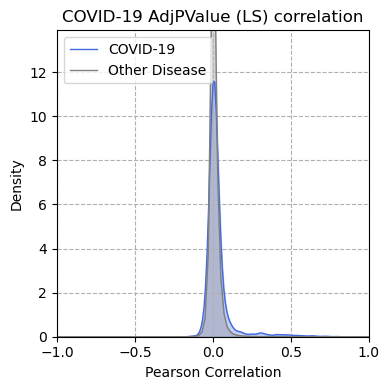

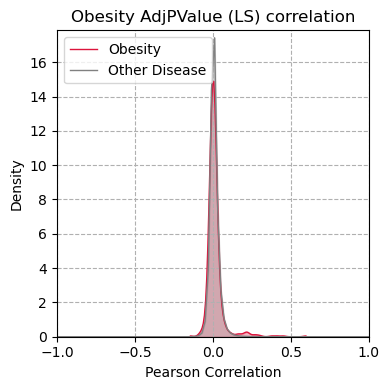

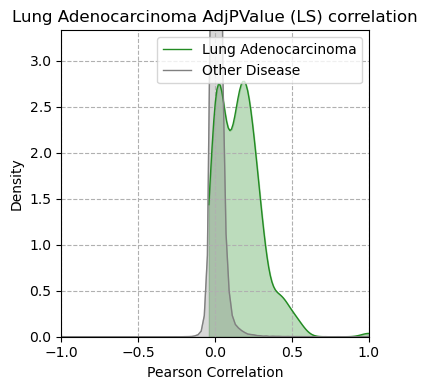

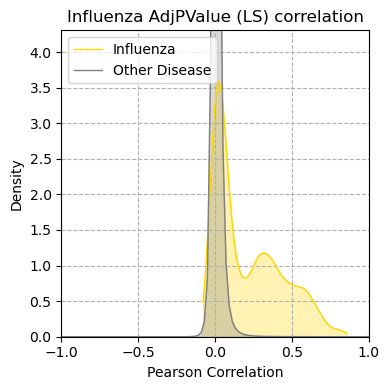

In [237]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


for i, disease in enumerate(tqdm(single_disease_examples)):

    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
    )

    # matrix interest
    matrix_interest = data_matrix_low_sp[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix_low_sp[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    value_1 = correlation_values_interest
    value_2 = correlation_values_rest

    # Plot setup
    plt.figure(figsize=(4, 4))

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

    # Finalizing plot
    title_example = f"{disease} {metric_evaluated} (LS) correlation "
    title_example = (
        title_example[:25] + " ..." if len(title_example) > 30 else title_example
    )

    plt.title(f"{disease} {metric_evaluated} (LS) correlation")
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.diseases_correlation.LS.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

'Other Dise'

In [215]:
colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]
colors[2]

'#228B22'

In [212]:
colors

{0: '#1E90FF', 1: '#FF7F50'}

## Adjusted p-Value Vectors

In [22]:
import numpy as np
from tqdm import tqdm


def compute_pearson_correlation(genes1, genes2, values1, values2):
    """
    Compute Pearson correlation between two gene signatures based on their common genes.
    """
    values1_dict = {gene: value for gene, value in zip(genes1, values1)}
    values2_dict = {gene: value for gene, value in zip(genes2, values2)}

    common_genes = set(genes1) & set(genes2)
    common_values1 = [values1_dict[g] for g in common_genes]
    common_values2 = [values2_dict[g] for g in common_genes]

    return np.corrcoef(common_values1, common_values2)[0, 1]


# Initialize a list to store the Pearson correlation coefficients.
same_disease_corr = []

# Iterate over diseases with high counts.
for disease in diseases_high_counts:
    dsaids_interest = disease_2_dsaids.get(disease, [])
    # Ensure only dsaids present in all_dsaids are processed to avoid ValueError.
    indexes_same_disease = [
        all_dsaids.index(d) for d in dsaids_interest if d in all_dsaids
    ]

    # Compute correlations avoiding self-comparison and duplicate comparisons.
    for i, index_i in enumerate(tqdm(indexes_same_disease)):
        for index_j in indexes_same_disease[
            i + 1 :
        ]:  # Start from the next item to avoid duplicates and self-comparison
            corr = compute_pearson_correlation(
                signatures[index_i][2],  # Genes list for signature i
                signatures[index_j][2],  # Genes list for signature j
                signatures[index_i][
                    4
                ],  # Values (e.g., adjusted p-values) for signature i
                signatures[index_j][4],  # Values for signature j
            )
            same_disease_corr.append(corr)

    # for i in tqdm(indexes_same_disease):
    #     for j in indexes_other_disease:
    #         same_disease_corr.append(
    #             compute_pearson_correlation(
    #                 signatures[i][2],
    #                 signatures[j][2],
    #                 signatures[i][4],
    #                 signatures[j][4],
    #             )
    #         )
    break

  0%|          | 0/152 [00:00<?, ?it/s]/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
  3%|▎         | 5/152 [00:03<01:35,  1.54it/s]/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 152/152 [00:55<00:00,  2.73it/s]


## logFC Vectors

## iLINCS Vectos

In [ ]:
##